# Visualization of CYP2D6 Genotyping from Cyrius

This script is meant to visualize the result of CYP2D6 genotyping from Cyrius, based on the paper https://www.nature.com/articles/s41397-020-00205-5, Figure 2B and 2C

## Plotting

In [3]:
import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

In [62]:
def visualize_2d6_cyrius(json_path, prefix_file, genome):
    #Get copy number information from json
    f = open(json_path)
    json_data = json.load(f)
    snp_call = json_data[prefix_file]['d67_snp_raw']
    snp_list = snp_call.split(',')
    snp = [float(i) for i in snp_list] #convert the list of string to float
    
    #Get position from auxiliary file
    if genome == "38":
        aux_path = '/data/NGS/Cyrius/data/CYP2D6_SNP_38.txt'
    elif genome == '37':
        aux_path = '/data/NGS/Cyrius/data/CYP2D6_SNP_37.txt'
        
    aux_df = pd.read_csv(aux_path, delimiter='\t',skiprows=1,header=None)
    #aux_df = aux_df.rename(columns={0:'chr#',1:'pos_CYP2D6'})
    pos = aux_df[1]
    
    #Get the scatter plot1
    fig1, ax1 = plt.subplots()
    fig1.suptitle('Figure B', fontsize=20)
    ax1.scatter(pos,snp,s=1.7)
    if genome == '38':
        ax1.set(xlabel='Position (kb)',ylabel='Raw CYP2D6 CN', xlim=[42125000,42133000], ylim=[0,4])
    elif genome == '37':
        ax1.set(xlabel='Position (kb)',ylabel='Raw CYP2D6 CN', xlim=[42521000,42529000], ylim=[0,4])
    ax1.grid()
    ax1.legend(['CYP2D6/CYP2D7 differentiating sites'], loc = 'upper left')
    
    #Exon Region CYP2D4-204
    if genome == '38':
        start = [42126499,42126851,42127447,42127842,42128174,42128784,42129033,42129738,42130612]
    elif genome == '37':
        start = [42522576,42522853,42523449,42523844,42524176,42524786,42525035,42525740,42526614]
    
    length = [178,141,187,141,176,160,152,171,198]
    for i in range(0,len(start)):
        ax1.bar(start[i],0.4,length[i],fc='khaki', align ='edge')
        ax1.annotate(9-i,xy=(start[i]+length[i]/3.5,0.45),size=8)
        
    #Setup plot2
    fig2, ax2 = plt.subplots()
    fig2.suptitle('Figure C', fontsize=20)
    ax2.set(xlabel='Position (kb)', ylabel='Variant Read Count', ylim=[0,50])
    ax2.grid()

    #Exon Region CYP2D4-204 
    for i in range(0,len(start)):
        ax2.bar(start[i],2,length[i],fc='khaki', align ='edge')
        ax2.annotate(9-i,xy=(start[i]+length[i]/3.5,0.5),size=8)
    
    ### PLOTTING THE READ COUNT INFORMATION ###

    #Get the "variants_called" and "variant_raw_count" field from the json file
    var_call =  json_data[prefix_file]["Variants_called"]
    var_raw = json_data[prefix_file]["Variant_raw_count"]
    var_pos = []
    raw_count = []

    #Loop through the variants_called
    for i in var_call:
    #Obtain the variant position
        var_pos.append(int(i[2:10])) #assuming variants_called are in "g.########C>G" format where # are the position digits
        #Prosses to liftover the position from h38 to h37
        if genome == '37':
            with open('pos_37.txt') as f:
                target_data = f.read()
            js = json.loads(target_data)
            var_pos = list(map(str, var_pos))
            var_pos = [js.get(item,item)  for item in var_pos]
            var_pos = list(map(int, var_pos ))
    #Obtain its count from the variant_raw_count field
        raw_count.append(int(var_raw[i].split(',')[0])) #from '27,30' grab '27' since it stores the number of alt allele

    #Remove any duplicated variant calls while keeping its index. Then, use that index to obtain the data to be plotted
    uniq_pos, uniq_idx = np.unique(np.array(var_pos),return_index=True)
    uniq_call = np.array(var_call)[uniq_idx]
    var_raw_count = np.array(raw_count)[uniq_idx]

    #Plot it into our figure
    for i in range(0,len(uniq_pos)):
        #ax.bar(uniq_pos[i],var_raw_count[i],color='black',width=17) #commented to keep duplicated vars
        ax2.bar(var_pos[i],raw_count[i],color='black',width=17, bottom=2)
        ax2.text(x=uniq_pos[i]-400,y=var_raw_count[i]-2,s=uniq_call[i],size=8,rotation=45)


## Testing

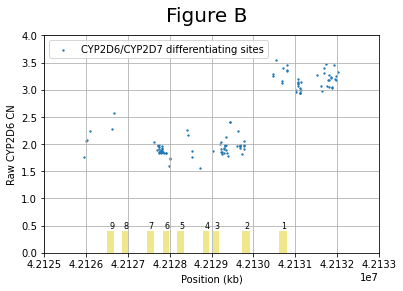

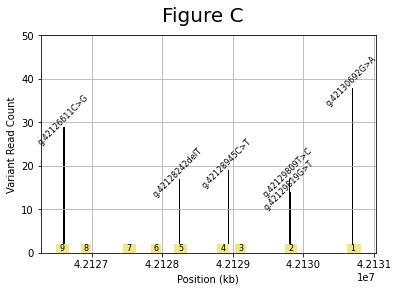

In [63]:
#GRCh38
json_path = '/home/ec2-user/rayo/cyrius_run_and_visualization/cyp2d6_35x_NA12878.json'
prefix_file = 'ERR3239334_35x'
genome = '38'

visualize_2d6_cyrius(json_path, prefix_file, genome)

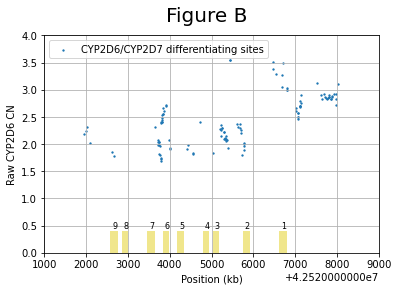

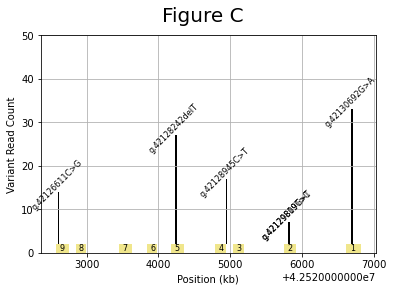

In [64]:
#GRCh37
json_path = '/home/ec2-user/rayo/cyrius_run_and_visualization/cyp2d6_GRCh37_NA12878_full.json'
prefix_file = 'NA12878_GRCh37'
genome = '37'

visualize_2d6_cyrius(json_path, prefix_file, genome)